#### надо установить opencv для python, если не установлен.
#### pip(pip3) install opencv-python

In [3]:
import cv2
import numpy as np
import torch
from sklearn import metrics
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 15),
         'axes.labelsize': '30',
         'axes.titlesize':'35',
         'xtick.labelsize':'30',
         'ytick.labelsize':'30'}
pylab.rcParams.update(params)

Пример получения вектора признаков для изображения

In [4]:
# далее задаются параметры HOG-a, они выставлены как в статье.
win_size = (64,128) 
block_size = (16,16)
block_stride = (8,8)
cell_size = (8,8)
nbins = 9
deriv_aperture = 1
win_sigma = -1
histogram_norm_type = 0
l2_hys_threshold = 2.0000000000000001e-01
gamma_correction = 0
nlevels = 64
hog = cv2.HOGDescriptor(win_size,block_size,block_stride,cell_size,nbins,deriv_aperture,win_sigma,
                        histogram_norm_type,l2_hys_threshold,gamma_correction,nlevels)


В базе INRIA размер изображений содержащих пешеходов  - 96х160(train) и 70x134(test). Человек расположен по центру.

Вам нужно получить вектор признаков(дескриптор) для окна 64х128. По умолчанию compute() строит дескрипторы для всех окон размером 64х128 методом скользящего окна, с шагом win_stride по обеим осям. Но если вам нужно получить дескриптор только для одного окна 64х128, то у метода есть аргумент locations, в котором можно передать координаты верхнего левого угла интересующего вас окна (либо список таких координат)

Например, для изображений из train извлечение центрального окна 64х128 выглядит следующим образом:

In [5]:
img = cv2.imread("crop_000010a.png")
height, width = img.shape[:2]
locations = [((width-64)//2, (height-128)//2)]
descriptor = hog.compute(img, locations=locations)
descriptor.size

3780

Изображения фона(отрицательные примеры)  - изображения произвольного размера. В обучающей выборке их 1218. Авторы HOG для обучения выбирали рандомно 10 окон 64х128 из каждого изображения  - всего 12180 примеров, не содержащих пешеходов.

Для этого, например, можно посчитать дескрипторы по всему изображению с win_stride=(4,4) и потом рандомно выбрать 10 из них.

Такие манипуляции вам надо проделать в цикле со всеми изображениями из train: для изображений из папки pos/ выбирать центральное окно, а из папки neg/ - 10 рандомных окон. Собрать их в np.array  или список, как вам будет удобно ну и в файл сохранить тоже.

Для того чтобы получить ответ svm классификатора у класса HOGDescriptor есть метод detect(). Этот метод вам понадобится, чтобы строить кривые качества (DET кривые). Метод detect() работает похожим образом с compute().
Только перед его использованием нужно задать веса SVM:

    hog.setSVMDetector(hog.getDefaultPeopleDetector()) - используется веса из opencv для HOG, обученного на INRIA
В остальном поробуйте сами с detect() разобраться. Если не получится - пишите.

Гайд по построению DET кривых позже добавлю

# Выделим признаки на позитивных картинках

In [6]:
win_stride = (8,8) #шаг скользящего окна в пикселях по ширине и высоте
def imHOG(path_to_image):
    img = cv2.imread(path_to_image)
    height, width = img.shape[:2]
    locations = [((width-64)//2, (height-128)//2)]
    descriptor = hog.compute(img, locations=locations)
    return descriptor

In [7]:
import pandas as pd

images = open("pos.lst")
string = images.read()
images = string.split("\n")
for i in range(len(images)):
    images[i] = images[i][10:]
images = images[:-1]

In [8]:
pos = []
for i in range(len(images)):
    #desc_file.write(str(imHOG(images[i]))+"\n")
    descriptor_current = imHOG(images[i])
    pos.append(descriptor_current)

In [9]:
images = open("pos_test.lst")
string = images.read()
images = string.split("\n")
for i in range(len(images)):
    images[i] = images[i][9:]
images = images[:-1]


In [10]:
pos_test = []
for i in range(len(images)):
    #desc_file.write(str(imHOG(images[i]))+"\n")
    descriptor_current = imHOG(images[i])
    pos_test.append(descriptor_current)

# На негативных

In [11]:
win_stride = (8,8) #шаг скользящего окна в пикселях по ширине и высоте
def imHOG_neg(path_to_image):
    img = cv2.imread(path_to_image)
    win_stride = (4,4)
    #получаем дескрипторы изображения и приводим их к рамеру
    #(кол-во окон на изображении)х(рамер дескриптора одного окна)
    #рамер дексриптора для параметров HOG как в статье - 3780
    descriptors = hog.compute(img, win_stride).reshape(-1,3780)
    indexes = np.random.randint(descriptors.shape[0], size=10)
    ten_random_samples = descriptors[indexes]
    return ten_random_samples

In [12]:
images_neg = open("neg.lst")
string_neg = images_neg.read()
images_neg = string_neg.split("\n")
for i in range(len(images_neg)):
    images_neg[i] = images_neg[i][10:]
images_neg = images_neg[:-1]


In [13]:
neg = []
for i in range(int(len(images_neg))):  #use less neg pictures
    desc_hog = imHOG_neg(images_neg[i])
    for j in range (len(desc_hog)):
        neg.append(desc_hog[j])

In [14]:
images_neg = open("neg_test.lst")
string_neg = images_neg.read()
images_neg = string_neg.split("\n")
for i in range(len(images_neg)):
    images_neg[i] = images_neg[i][9:]a
images_neg = images_neg[:-1]

In [15]:
neg_test = []
for i in range(int(len(images_neg))):   #use less neg_test pictures
    desc_hog = imHOG_neg(images_neg[i])
    for descriptor_current in desc_hog:
        neg_test.append(descriptor_current)

# Решейпим полученные дескрипторы pos, pos_test, neg, neg_test

In [14]:
print(len(neg),len(neg_test),len(pos),len(pos_test))

12180 4530 2416 1132


In [15]:
for i in range(len(pos)):
    for j in range(3780):
        pos[i][j] = pos[i][j][0]
        
for i in range(len(pos_test)):
    for j in range(3780):
        pos_test[i][j] = pos_test[i][j][0]

In [16]:
def ReshapeOneHOG(hog):
    new_hog = []
    for i in range(15):
        new_hog.append([])
        new_hog.append([])
        for j in range(7):
            cell = ReshapeCell(hog[i*36*7+36*j : i*36*7+36*(j+1)])
            new_hog[2*i].append(cell[0])
            new_hog[2*i+1].append(cell[1])
            new_hog[2*i].append(cell[2])
            new_hog[2*i+1].append(cell[3])
    return new_hog
            
def ReshapeCell(cell):
    c = []
    c.append(cell[0:9])
    c.append(cell[9:18])
    c.append(cell[18:27])
    c.append(cell[27:36])
    return c

def Reshape_in(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array of 14 elem
        for j in range(0,15):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,7):
                b.append(Q[2*j*14*9+k*36+i])
                b.append(Q[2*j*14*9+k*36+i+18])
                c.append(Q[2*j*14*9+k*36+i+9])
                c.append(Q[2*j*14*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES

In [30]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


dropout = 0.5

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)    9x30x14
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(9, 18, kernel_size=3, stride=1, padding=1) #bias убрать!!
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(18, 36, kernel_size=5, stride=1, padding=1)
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(36 * 14 * 6, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 1)
        #self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)   9x30x14 to 18x30x14
        x = F.relu(self.conv1(x))
        #print(x.shape)
        #print(x.shape)
        #to 18x14x6
        x = F.relu(self.conv2(x))   #to 36x14x6
        #print(x.shape)
        #print(x.shape)
        #Size changes from (18, 32, 32) to (18, 16, 16)  36x14x6 to 36x7x3
        x = self.pool(x)
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        #print(x.shape)
        x = x.view(-1, 36 * 14 * 6)
        #print(x.shape)
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        #print(x.shape)
        return F.sigmoid(x)

model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
# Train the model
for i in range(800):
    # Forward pass
    #xinput = torch.tensor(Reshape_in(neg[i]), dtype = torch.float32)
    inputs = []
    labels = []
    for j in range(3):
        inputs.append(Reshape_in(neg[9*i+3*j]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+1]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+2]))
        labels.append([0])
        inputs.append(Reshape_in(pos[3*i+j]))
        labels.append([1])
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    #print(inputs.shape, labels)

    outputs = model(inputs)
    #print(outputs)

    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        print ('Loss: {:.4f}' 
               .format(loss.item()))



/Users/tomininvladislav/env/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.5131
Loss: 0.5706
Loss: 0.0262
Loss: 0.2728


In [18]:
for h in np.linspace(0.4, 0.7, 4):
    inputs = []
    labels = []
    acc = 0
    for i in range(1100):

        inputs.append(Reshape_in(neg_test[2*i]))
        labels.append([0])
        inputs.append(Reshape_in(neg_test[2*i+1]))
        labels.append([0])
        inputs.append(Reshape_in(pos_test[i]))
        labels.append([1])
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    outputs = model(inputs)
    for j in range(len(inputs)):
        if outputs[j] > h:
            if labels[j] == 1:
                acc += 1
        else:
            if labels[j] == 0:
                acc += 1
    print("Accuracy {} h {}".format(round(acc/len(labels), 3), round(h,3)))

/Users/tomininvladislav/env/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy 0.855 h 0.4
Accuracy 0.875 h 0.5
Accuracy 0.868 h 0.6
Accuracy 0.845 h 0.7


## $$FNR = \frac{FN}{FN+TP}$$     
$$ FPR = \frac{FP}{FP+TN} $$

In [31]:
#det FNR(FPR)
inputs = []
labels = []
for i in range(1100):

    inputs.append(Reshape_in(neg_test[2*i]))
    labels.append([0])
    inputs.append(Reshape_in(neg_test[2*i+1]))
    labels.append([0])
    inputs.append(Reshape_in(pos_test[i]))
    labels.append([1])
inputs = torch.from_numpy(np.array(inputs))
labels = torch.tensor(labels, dtype = torch.float32)
outputs = model(inputs)


def det(neg_test, pos_test, h):

    fn = 0
    tp = 0
    fp = 0
    tn = 0
    
    for j in range(len(inputs)):
        if outputs[j] > h:
            if labels[j] == 1:
                tp += 1
            if labels[j] == 0:
                fn += 1
        else:
            if labels[j] == 0:
                tn += 1
            if labels[j] == 1:
                fp += 1
    fnr = fn/(fn+tp)
    fpr = fp/(fp+tn)
    return fnr, fpr





/Users/tomininvladislav/env/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [32]:
fpr = []  #x
fnr = []  #y

for h in np.linspace(0.1, 0.9, 200):
    y,x = det(neg_test, pos_test, h)
    fpr.append(x)
    fnr.append(y)
    #print(h)

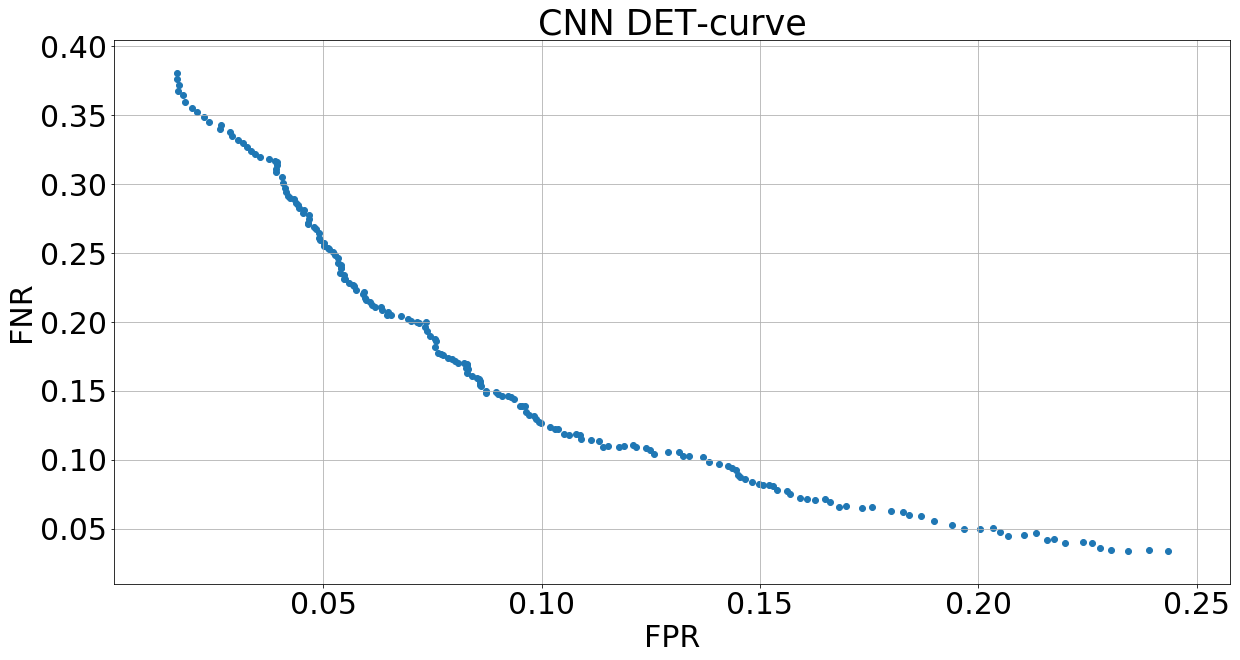

In [33]:
plt.figure(figsize=(20,10))
plt.title("CNN DET-curve")
plt.scatter(fpr, fnr)
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.grid()

## Построим полносвязную сеть и сравним результаты


In [39]:
pos_x = []
pos_test_x = []
for i in range(len(pos)):
    pos_x.append([])
    for j in range(3780):
        pos_x[i].append(pos[i][j][0])
        
for i in range(len(pos_test)):
    pos_test_x.append([])
    for j in range(3780):
        pos_test_x[i].append(pos_test[i][j][0])
pos = pos_x
pos_test = pos_test_x

IndexError: invalid index to scalar variable.

In [40]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(3780, 1200)
        self.fc2 = nn.Linear(1200, 200)
        self.fc3 = nn.Linear(200, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.sigmoid(x)
    

    
model = FCN()
criterion = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

# Train the model
for i in range(800):
    # Forward pass
    #xinput = torch.tensor(Reshape_in(neg[i]), dtype = torch.float32)
    inputs = []
    labels = []
    for j in range(3):
        inputs.append(neg[9*i+3*j])
        labels.append([0])
        inputs.append(neg[9*i+3*j+1])
        labels.append([0])
        inputs.append(neg[9*i+3*j+2])
        labels.append([0])
        inputs.append(pos[3*i+j])
        labels.append([1])
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    #print(inputs.shape, labels)

    outputs = model(inputs)
    #print(outputs)

    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        print ('Loss: {:.4f}' 
               .format(loss.item()))




/Users/tomininvladislav/env/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.5488
Loss: 0.0740
Loss: 0.0075
Loss: 0.0914


/Users/tomininvladislav/env/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


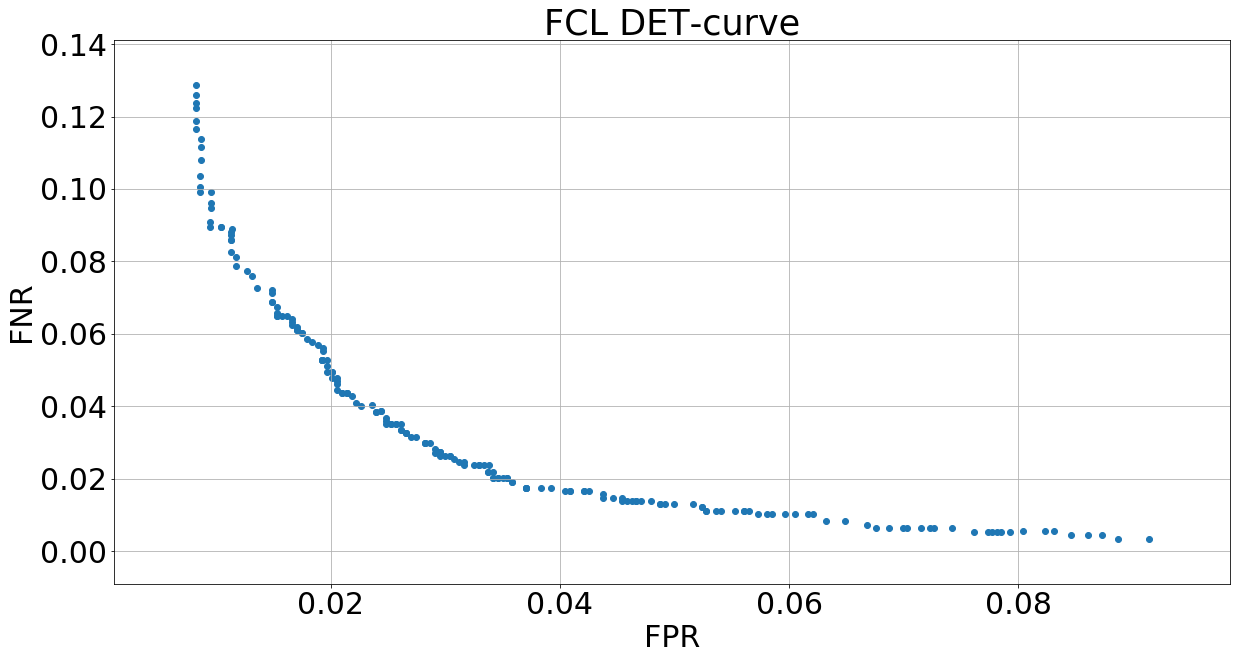

In [41]:
#det FNR(FPR)
inputs = []
labels = []
for i in range(1100):

    inputs.append(neg_test[2*i])
    labels.append([0])
    inputs.append(neg_test[2*i+1])
    labels.append([0])
    inputs.append(pos_test[i])
    labels.append([1])
inputs = torch.from_numpy(np.array(inputs))
labels = torch.tensor(labels, dtype = torch.float32)
outputs = model(inputs)



fpr = []  #x
fnr = []  #y

for h in np.linspace(0.1, 0.9, 200):
    y,x = det(neg_test, pos_test, h)
    fpr.append(x)
    fnr.append(y)
    #print(h)

plt.figure(figsize=(20,10))
plt.title("FCL DET-curve")
plt.scatter(fpr, fnr)
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.grid()

# Пробуем менять параметры CNN на 
INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC

In [25]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


dropout = 0.5

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)    9x30x14
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(9, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(18, 36, kernel_size=5, stride=1, padding=1)
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(36 * 14 * 6, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #9x30x14 to 18x30x14
        x = F.relu(self.conv1(x))
        #print(x.shape)
        #18x30x14 to 18x15x7
        #print(x.shape)
        #18x15x7 to 36x13x5
        x = F.relu(self.conv2(x))   #to 36x14x6
        #print(x.shape)
        #36x13x5 to 36x6x2
        x = self.pool(x)
        #x = self.pool(x)
        #print(x.shape)
        x = x.view(-1, 36 * 14 * 6)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #print(x.shape)
        return F.sigmoid(x)

model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
# Train the model
for i in range(800):
    # Forward pass
    #xinput = torch.tensor(Reshape_in(neg[i]), dtype = torch.float32)
    inputs = []
    labels = []
    for j in range(3):
        inputs.append(Reshape_in(neg[9*i+3*j]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+1]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+2]))
        labels.append([0])
        inputs.append(Reshape_in(pos[3*i+j]))
        labels.append([1])
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    #print(inputs.shape, labels)

    outputs = model(inputs)
    #print(outputs)

    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        print ('Loss: {:.4f}' 
               .format(loss.item()))




/Users/tomininvladislav/env/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.5117
Loss: 0.6690
Loss: 0.1274
Loss: 0.3052


In [26]:

inputs = []
labels = []
for i in range(1100):

    inputs.append(Reshape_in(neg_test[2*i]))
    labels.append([0])
    inputs.append(Reshape_in(neg_test[2*i+1]))
    labels.append([0])
    inputs.append(Reshape_in(pos_test[i]))
    labels.append([1])
inputs = torch.from_numpy(np.array(inputs))
labels = torch.tensor(labels, dtype = torch.float32)
outputs = model(inputs)


fpr = []  #x
fnr = []  #y

for h in np.linspace(0.1, 0.9, 200):
    y,x = det(neg_test, pos_test, h)
    fpr.append(x)
    fnr.append(y)
    #print(h)



plt.figure(figsize=(20,10))
plt.title("CNN DET-curve")
plt.scatter(fpr, fnr)
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.grid()

/Users/tomininvladislav/env/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ZeroDivisionError: division by zero

In [3]:
images_pos = open("pos.lst")
string = images_pos.read()
images_pos = string.split("\n")
for i in range(len(images_pos)):
    images_pos[i] = images_pos[i][10:]
images_pos = images_pos[:-1]

images_pos_test = open("pos_test.lst")
string = images_pos_test.read()
images_pos_test = string.split("\n")
for i in range(len(images_pos_test)):
    images_pos_test[i] = images_pos_test[i][9:]
images_pos_test = images_pos_test[:-1]

images_neg = open("neg.lst")
string = images_neg.read()
images_neg = string.split("\n")
for i in range(len(images_neg)):
    images_neg[i] = images_neg[i][10:]
images_neg = images_neg[:-1]

images_neg_test = open("neg_test.lst")
string = images_neg_test.read()
images_neg_test = string.split("\n")
for i in range(len(images_neg_test)):
    images_neg_test[i] = images_neg_test[i][9:]
images_neg_test = images_neg_test[:-1]




In [4]:

answer = [] 
for t in images_pos_test: 
    img = cv2.imread(t) 
    height, width = img.shape[:2] 
    y = (height - 131)//2 
    x = (width - 67)//2 
    img = img[y:y+128, x:x+64] 
    descriptors = hog.compute(img, winStride = (1, 1)).reshape(-1, 3780) 
    answer.append(max(model(torch.tensor(descriptors))))


for t in images_neg_test: 
    img = cv2.imread(t) 
    descriptors = hog.compute(img, winStride = win_stride).reshape(-1,3780) 
    res = model(torch.tensor(descriptors)) 
    for rs in res: 
        answer.append(rs)
 

NameError: name 'cv2' is not defined

In [1]:
answ = [] 
for i in range(0, len(answer)): 
    answ.append(answer[i])



NameError: name 'answer' is not defined

In [ ]:
Ytest = [] 
for i in range(0, len(TestPos)): 
    Ytest.append(1) 
for i in range(0, len(answ) - len(TestPos)): 
    Ytest.append(0)



In [ ]:
fpr, tpr, tr = roc_curve(Ytest, answ) 
det = [] 
for t in tpr: 
    det.append(1 - t)

In [22]:
def subl_nbins(h):
    fig, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3 , figsize=(20, 10), sharex=True, sharey=True)
    print(h[0][:][:].shape)
    ax1.axis('off')
    ax1.imshow(h[0])
    ax1.set_title('Input image')
    
    ax2.axis('off')
    ax2.imshow(h[1])
    ax2.set_title('Input image')
    
    ax3.axis('off')
    ax3.imshow(h[2])
    ax3.set_title('Input image')
    
    ax4.axis('off')
    ax4.imshow(h[3])
    ax4.set_title('Input image')
    
    ax5.axis('off')
    ax5.imshow(h[4])
    ax5.set_title('Input image')
    
    ax6.axis('off')
    ax6.imshow(h[5])
    ax6.set_title('Input image')
    
    ax7.axis('off')
    ax7.imshow(h[6])
    ax7.set_title('Input image')
    
    ax8.axis('off')
    ax8.imshow(h[7])
    ax8.set_title('Input image')
    
    ax9.axis('off')
    ax9.imshow(h[8])
    ax9.set_title('Input image')
    # Rescale histogram for better display
    
    

[0.]
0.0
(9, 14, 30)
(14, 30)



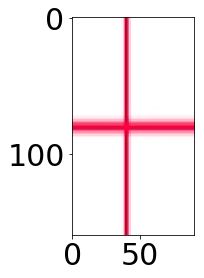

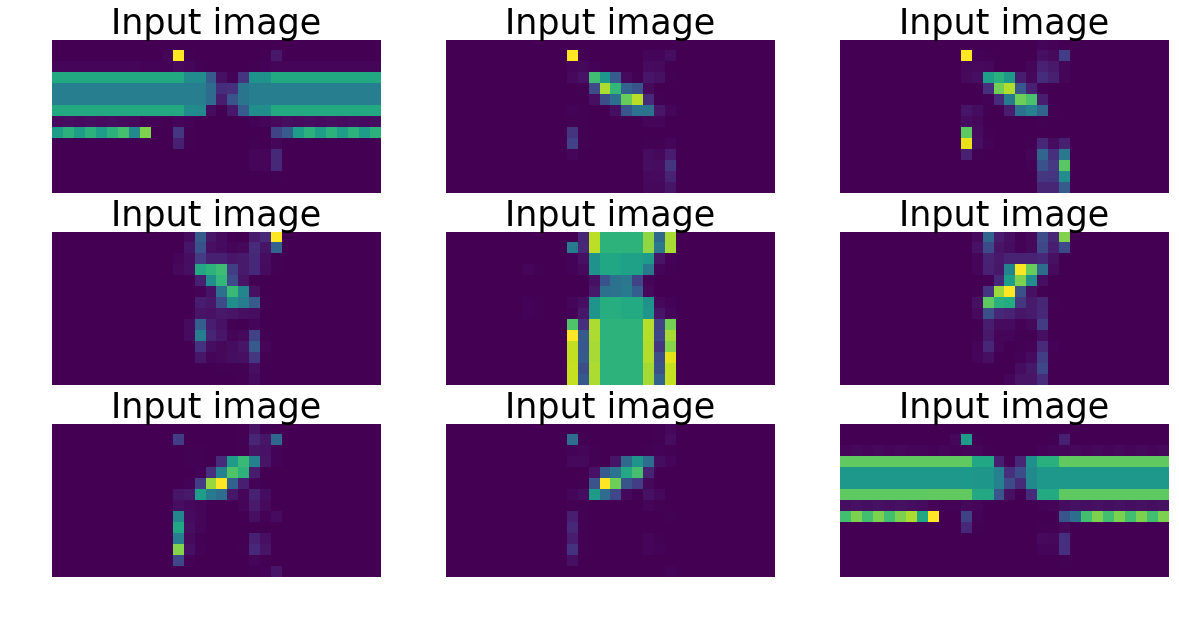

In [58]:
#try.PNG
#path='/Users/tomininvladislav/Desktop/ee.png'
path='/Users/tomininvladislav/Desktop/kk.jpg'
img = cv2.imread(path)
plt.imshow(img)
win_size = (64,128) 
block_size = (16,16)
block_stride = (8,8)
cell_size = (8,8)
nbins = 9
deriv_aperture = 1
win_sigma = -1
histogram_norm_type = 0
l2_hys_threshold = 2.0000000000000001e-01
gamma_correction = 0
nlevels = 64
hog = cv2.HOGDescriptor(win_size,block_size,block_stride,cell_size,nbins,deriv_aperture,win_sigma,
                        histogram_norm_type,l2_hys_threshold,gamma_correction,nlevels)
img = cv2.imread(path)
#img1 = cv2.imread(path1)
#plt.imshow(img)
win_stride = (8,8)
height, width = img.shape[:2]
locations = [((height-128)//2, (width-64)//2)]
descriptor = hog.compute(img, locations=locations)
#descriptor1 = hog.compute(img1, locations=locations)
d=[]
#d1=[]
for i in range(0,len(descriptor)):
    d.append(descriptor[i][0])
    #d1.append(descriptor1[i][0])
print(descriptor[3])
print(d[3])


hog_new=Reshape_in(d)
#hog_new1=Reshape_in1(d)



h=np.array(hog_new)
#h1=np.array(hog_new1)




print(h.shape)
subl_nbins(h)
#subl_nbins(h1)



print()

In [28]:
def Reshape_in(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array of 14 elem
        for j in range(0,7):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,15):
                b.append(Q[2*j*30*9+k*36+i])
                c.append(Q[2*j*30*9+k*36+i+18])
                b.append(Q[2*j*30*9+k*36+i+9])
                c.append(Q[2*j*30*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES

In [82]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


dropout = 0.5

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)    9x30x14
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(9, 18, kernel_size=3, stride=1, padding=0)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(18, 36, kernel_size=5, stride=1, padding=1)
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(36 * 13 * 5, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 1)
        #self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)   9x30x14 to 18x30x14
        x = F.relu(self.conv1(x))
        #print(x.shape)
        #print(x.shape)
        #to 18x14x6
        x = F.relu(self.conv2(x))   #to 36x14x6
        #print(x.shape)
        #print(x.shape)
        #Size changes from (18, 32, 32) to (18, 16, 16)  36x14x6 to 36x7x3
        x = self.pool(x)
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        #print(x.shape)
        x = x.view(-1, 36 * 13 * 5)
        #print(x.shape)
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        #print(x.shape)
        return F.sigmoid(x)

model = SimpleCNN()
criterion = nn.BCELoss()
#optimizer = optim.Adagrad(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
# Train the model
for i in range(800):
    # Forward pass
    #xinput = torch.tensor(Reshape_in(neg[i]), dtype = torch.float32)
    inputs = []
    labels = []
    for j in range(3):
        inputs.append(Reshape_in(neg[9*i+3*j]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+1]))
        labels.append([0])
        inputs.append(Reshape_in(neg[9*i+3*j+2]))
        labels.append([0])
        inputs.append(Reshape_in(pos[3*i+j]))
        labels.append([1])
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    #print(inputs.shape, labels)

    outputs = model(inputs)
    #print(outputs)

    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        print ('Loss: {:.4f}' 
               .format(loss.item()))




/Users/tomininvladislav/env/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.4644
Loss: 0.5385
Loss: 0.0008
Loss: 0.0646


In [83]:
#det FNR(FPR)
inputs = []
labels = []
for i in range(1100):

    inputs.append(Reshape_in(neg_test[2*i]))
    labels.append([0])
    inputs.append(Reshape_in(neg_test[2*i+1]))
    labels.append([0])
    inputs.append(Reshape_in(pos_test[i]))
    labels.append([1])
inputs = torch.from_numpy(np.array(inputs))
labels = torch.tensor(labels, dtype = torch.float32)
outputs = model(inputs)


def det(neg_test, pos_test, h):

    fn = 0
    tp = 0
    fp = 0
    tn = 0
    
    for j in range(len(inputs)):
        if outputs[j] > h:
            if labels[j] == 1:
                tp += 1
            if labels[j] == 0:
                fn += 1
        else:
            if labels[j] == 0:
                tn += 1
            if labels[j] == 1:
                fp += 1
    fnr = fn/(fn+tp)
    fpr = fp/(fp+tn)
    return fnr, fpr






/Users/tomininvladislav/env/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [84]:
fpr = []  #x
fnr = []  #y

for h in np.linspace(0.1, 0.7, 200):
    y,x = det(neg_test, pos_test, h)
    fpr.append(x)
    fnr.append(y)
    #print(h)

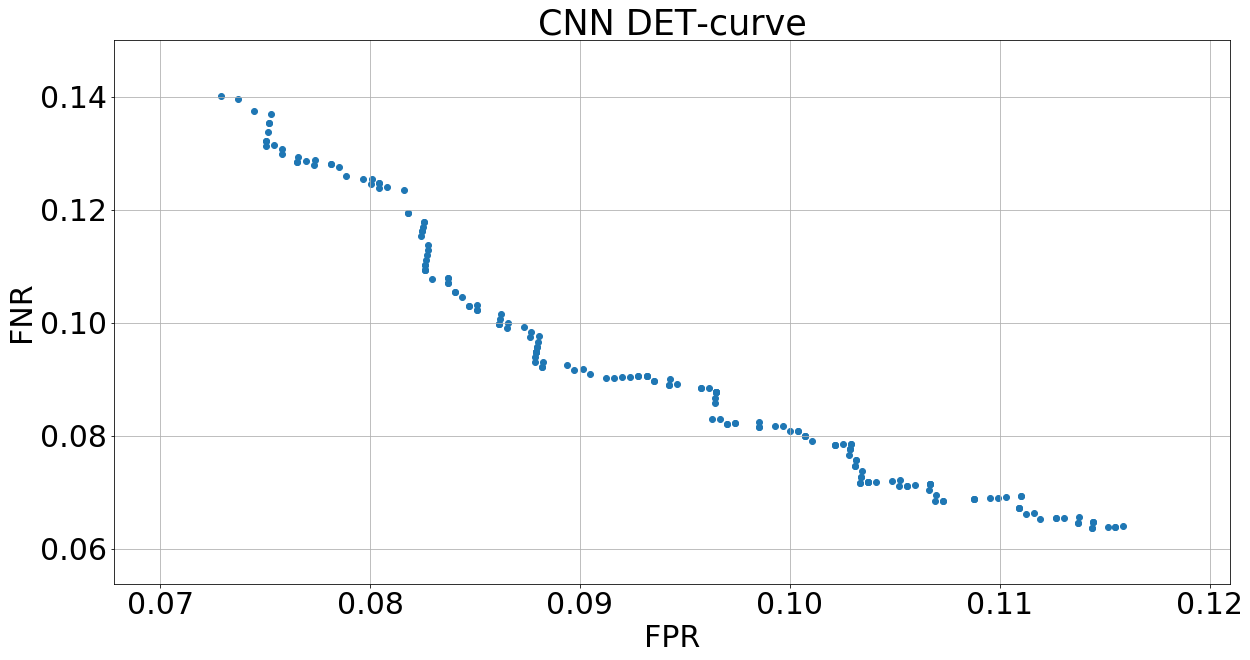

In [85]:
plt.figure(figsize=(20,10))
plt.title("CNN DET-curve")
plt.scatter(fpr, fnr)
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.grid()